# SKLearn & ONNX 

This notebook has been built based on [this tutorial](http://onnx.ai/sklearn-onnx/auto_examples/plot_intermediate_outputs.html). Here we investigate the process of conversion of different [SKLearn](https://scikit-learn.org/stable/) models to the [ONNX](https://onnx.ai/) format and compares these models' performance. For performing experiments, we selected the "titanic" classification data set. It contains a combination of numeric and categorical features. This combination of features is useful for assembling and testing the data preprocessing pipeline.

But before we start let's prepare our working environment.

In [9]:
# Let's create a temporary directory for the artifact created by this notebook.
# This way, we will not make a mess in the root project space.
import os

if not os.path.exists('tmp'):
    os.makedirs('tmp')

## Prepare Dataset

For creating ML models we loaded the "Titanic" dataset and selected the following features:

| Feature      | Kind       | Type    | Enforce(*) |
| ----------- | ----------- | ------- | ---------- |
| Pclass      | categorical | str     | yes        |
| Sex         | categorical | str     | no         |
| Age         | numeric     | float32 | yes        |
| Fare        | numeric     | float32 | yes        |

(*) We will need to enforce types for features which original type were incorrectly detected.


The Pandas loader detects the "Pclass" - passenger class feature as **int** type. We forced the conversion of this feature to the **str** type.  Since, according to the documentation, ONNX one-hot encoder cannot perform the implicit conversions.

We also forced the conversion of both numeric fields "Age" and "Fare" from **float64** to **float32**. For our experiments, we do not need this precision.

In [10]:
import numpy as np
from utils import load_dataset

# Sets the loading dataset name.
dataset_name = 'titanic'

# Loads the dataset.
dataset = load_dataset(dataset_name)

# In the documentation: 
# http://onnx.ai/sklearn-onnx/auto_examples/plot_intermediate_outputs.html
# we have the following recommendation: "scikit-learn does implicit conversions
#  when it can. sklearn-onnx does not. The ONNX version of OneHotEncoder must
# be applied on columns of the same type."
# TODO: we need to investigate it, but for now, let's follow the instruction
# for type conversion.
dataset['Pclass'] = dataset['Pclass'].astype(str)

# Lets select "float32" for the numeric columns.
dataset['Age'] = dataset['Age'].astype(np.float32)
dataset['Fare'] = dataset['Fare'].astype(np.float32)

# Splits data into training (2/3) and test (1/3).
train, test = dataset.train_test_split()

print('Loaded "%s" datase:' % dataset_name)
print('   - number of training samples: %d' % len(train))
print('   - number of test samples:     %d' % len(test))


Loaded "titanic" datase:
   - number of training samples: 594
   - number of test samples:     293


## Train & Test SKLearn Model

For conducting experiments, we selected six SKLearn classifiers listed below:

| Classifier  | SKLearn Class |
| ----------- | ------------- |
| knn         | [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html?highlight=kneighborsclassifier#sklearn.neighbors.KNeighborsClassifier) |
| lr          | [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logisticregression#sklearn.linear_model.LogisticRegression) |
| rf          | [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=randomforestclassifier#sklearn.ensemble.RandomForestClassifier) |
| svm         | [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html?highlight=svc#sklearn.svm.SVC) |
| nb          | [GaussianNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html?highlight=gaussiannb#sklearn.naive_bayes.GaussianNB) |
| mlp         | [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html?highlight=mlpclassifier#sklearn.neural_network.MLPClassifier) |

If this list is not comprehensive for your experiment, feel free to add there your classification model. Make sure that your model is supported ONNX conversion using [this documentation](https://onnx.ai/sklearn-onnx/supported.html).

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

classifier = {
    'knn': KNeighborsClassifier(),
    'lr': LogisticRegression(random_state=42),
    'rf': RandomForestClassifier(random_state=42),
    'svm': SVC(random_state=42, probability=True),
    'nb': GaussianNB(),
    'mlp': MLPClassifier(random_state=42)
}

Then we create a training pipeline which is a combination of data preprocessor and classifier. The data preprocessor provides different steps for handling numeric and categorical features. For more information review the utility function **create_preprocessor** in the **utils** module.

**Please note**, our goal for this tutorial is not to create the best classification model for the "titanic" dataset. So we will not focus on picking the best feature and optimizing hyperparameters of the different classifiers. Our goal is to learn more about ONNX! :wink:

In the example below, we selected the k-nearest neighbor classifier. But when you clone this project pick your own one ("knn", "lr", "rf", "svm", "nb", or "mlp") for the experiment.

For the "knn" we trained the ML model showing an accuracy of **81%**. 

In [12]:
from utils import create_preprocessor

from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline

# Creates a data preprocessing pipeline.
preprocessor = create_preprocessor(dataset)

# Defines the model as a pipeline which combines a data preprocessor and 
# a calssifier.
classifier_name = 'rf'
model = Pipeline(steps=[
    ('precprocessor', preprocessor),
    ('classifier', classifier[classifier_name])
])

# Trains the model.
model.fit(train.X, train.y)

# Uses the model for scoring.
y_sklearn_pred = model.predict(test.X)          # collects the predicted labels;
y_sklearn_probas = model.predict_proba(test.X)  # collects the prediction probabilities;

# Just for convenience name the test.y labels as the ground truth.
y_true = test.y

# Computes the accuracy score.
sklearn_accuracy = accuracy_score(y_true, y_sklearn_pred)
print('The model accuracy: %.2f' % sklearn_accuracy)

The model accuracy: 0.81


## Convert Model To ONNX

Next, we need to convert the SKLearn model to ONNX format and serialize it to the file. The conversion process is simple. It is performed by the convert_sklearn function, assuming that your classifier and preprocessing elements are supported by ONNX.

One important aspect you need to focus on is setting correct input types. To do we provided the utility function **get_onnx_input_type** defined in the **utils** module. It takes the training dataset and uses it to guess and generate ONNX input types. This function was created to be generic, so we can reuse it in different notebooks. In practice, you can optimize the input types to feet best your data.

In [13]:
import os
from utils import get_onnx_input_type
from skl2onnx import convert_sklearn

# Creates input type using dataset schema.
initial_type = get_onnx_input_type(train)

# Converts the model to the ONNX format.
onnx_filename = 'model.onnx'
onnx_model = convert_sklearn(model, initial_types=initial_type)

# Serializes the ONNX model to the file.
with open(os.path.join('tmp', onnx_filename), "wb") as f:
    f.write(onnx_model.SerializeToString())
    print('The ONNX model has been successfully saved in "model.onnx" file.')

The ONNX model has been successfully saved in "model.onnx" file.


## Load & Test ONNX Model

To load the model, we just need to specify its file name in the runtime. 

Unfortunately, we cannot use the test Pandas data frame directly for inference. The data entering the ONNX model has to be transformed in a slightly different format. For doing this transformation we are using the **get_onnx_input_data** function defined in the **utils** module. This function converts the  Pandas data frame:

```
      Age       Fare Pclass     Sex
296  47.0  30.500000      1    male
682  25.0  41.579201      2    male
535  69.0  14.500000      3    male
644  56.0  35.500000      1    male
623  57.0  12.350000      2    male
..    ...        ...    ...     ...
377  19.0   7.775000      3    male
140  22.0   7.750000      3  female
173  56.0  30.695801      1    male
6    54.0  51.862499      1    male
731  28.5  16.100000      3    male
```

in the following dictionary:

```
{'Age': array([[47.  ],
       [25.  ],
       [69.  ],
       [56.  ],
       [57.  ],
       ...], dtype=float32), 
'Fare': array([[ 30.5   ],
       [ 41.5792],
       [ 14.5   ],
       [ 35.5   ],
       [ 12.35  ],
       ...], dtype=float32),
'Pclass': array([['1'],
       ['2'],
       ['3'],
       ['1'],
       ['2'],
       ...], dtype=object),
'Sex': array([['male'],
       ['male'],
       ['male'],
       ['male'],
       ...], dtype=object)}
```

This dictionary can be used now for inference using the ONNX model. The accuracy of the ONNX model to the same data we were used for score SKLearn model is the same 81%. So we can conclude that both models are the same.

In [14]:
from utils import get_onnx_input_data
import onnxruntime as rt

input_data = get_onnx_input_data(test)

sess = rt.InferenceSession(os.path.join('tmp', onnx_filename))
y_onnx_pred, y_onnx_probas = sess.run(None, input_data)
onnx_accuracy = accuracy_score(test.y, y_onnx_pred)
print('The ONNX model accuracy: %.2f' % onnx_accuracy)

The ONNX model accuracy: 0.81


## Compare SKLearn & ONNX Models 

Even we do not expect a difference between SKLearn and ONNX models' accuracies,  let's visualize the confusion matrix. In this confusion matrix, we will consider predictions generated by the SKLearn model as a ground truth (GT).

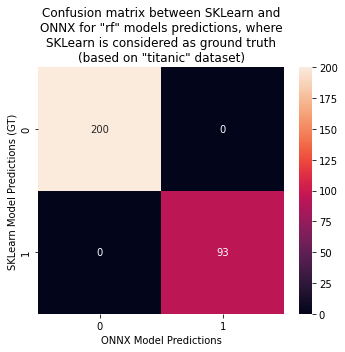

In [15]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

# Creates the confusion matrix.
cm = confusion_matrix(y_sklearn_pred, y_onnx_pred)
df_cm = pd.DataFrame(cm, range(2), range(2))

# Makes a confusion matrix plot.
fig, ax = plt.subplots(figsize=(5,5))
sn.heatmap(df_cm, annot=True, fmt='d', ax=ax)
ax.set_title( f'Confusion matrix between SKLearn and\nONNX for "{classifier_name}" models predictions, where\nSKLearn is considered as ground truth\n(based on "{dataset_name}" dataset)' )
ax.set_xlabel("ONNX Model Predictions")
ax.set_ylabel("SKLearn Model Predictions (GT)")
plt.tight_layout()

However, we expect some differences in prediction probabilities. To visualize these differences, we substruct  ONNX probabilities from SKLearn probabilities, and then plot distribution of the obtained differences using a box plot.

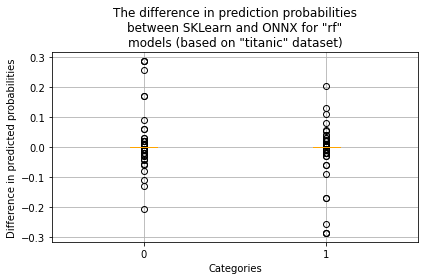

In [16]:
# Convert SKLearn and ONNX probabilities into Pandas data frame. This will
# help us to perform mathematical operations later.
df_sklearn_probas = pd.DataFrame(y_sklearn_probas)
df_onnx_probas = pd.DataFrame(y_onnx_probas)

# Computes a difference between SKLearn and ONNX probabilities.
df_diff = df_sklearn_probas - df_onnx_probas

# Makes a Box plot.
poxplot = df_diff.boxplot(color={'medians': 'orange'})
plt.title( f'The difference in prediction probabilities\nbetween SKLearn and ONNX for "{classifier_name}"\nmodels (based on "{dataset_name}" dataset)' )
plt.xlabel("Categories")
plt.ylabel("Difference in predicted probabilities")
plt.tight_layout()
plt.savefig(os.path.join('tmp', f'diff_{classifier_name}.jpg'))